In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import zipfile
import io
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim

In [19]:
def read_h5py(zip_filename):

    folder_name = 'dsp'
    use_channels = [0, 1, 2]

    X_reshaped, X, Y, S = [], [], [], []

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.startswith(folder_name) and not file_info.is_dir():
                # Extract the file from the zip archive
                with zip_ref.open(file_info) as hdf5_file:
                    with h5py.File(io.BytesIO(hdf5_file.read()), 'r') as hdf5_data:
                      for use_channel in use_channels:
                        row = hdf5_data['ch{}'.format(use_channel)][()]
                        X.append(row)
                        row_reshaped = []
                        for index, x in enumerate(row):
                            row_reshaped.append(x.reshape(32, 32))
                        X_reshaped.append(np.array(row_reshaped))
                        Y.append(hdf5_data['label'][()][0])
                        S.append(file_info.filename.replace("dsp/", "").split("_")[0])
    return np.array(X, dtype="object"), np.array(X_reshaped, dtype="object"), np.array(Y, dtype="object"), np.array(S, dtype="object")

In [85]:
X_reshaped, X, Y, S = read_h5py('SoliData.zip')

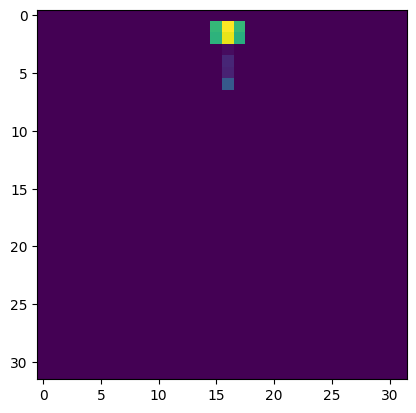

In [86]:
plt.imshow(X[2][0])

In [6]:
def apply_cov(X):
    X_cov = np.zeros(shape=X.shape , dtype='object')
    for index, x in enumerate(X):
        x_transpose = np.transpose(x)
        X_cov[index] = np.cov(x_transpose)
    return X_cov

# Leave one out cross validation

In [59]:
def leave_one_out_crosse_split(X, Y, S, s):
  print(f'Subject number : {s}')
  X_train, Y_train, X_test, Y_test = [], [], [], []
  for index, v in enumerate(X):
    if S[index] == s:
      X_test.append(v)
      Y_test.append(Y[index])
    else:
      X_train.append(v)
      Y_train.append(Y[index])
  return np.array(X_train), np.array(Y_train, dtype='int'), np.array(X_test), np.array(Y_test, dtype='int')

In [7]:
def leave_one_out_cross_score(X, Y, S, train_method, showError=False):

  predectid_labels = []
  accuracy = []
  Iterations = []

  subjects = np.unique(S)

  for i, s in enumerate(subjects):
    X_train, Y_train, X_test, Y_test = leave_one_out_crosse_split(X, Y, S, s)
    
    score = train_method(X_train, X_test, Y_train, Y_test, eval=False)
    accuracy.append(score)
    Iterations.append(i)

  if (showError):
    plt.plot(Iterations, accuracy)
    # Add labels and title
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Accuracy per Iteration')

  score = np.mean(np.array([accuracy]))

  return score

# Augmentation de la donné (TIME SHIFT + SPECAUGMENT + SPECCOUTOUT)

In [8]:
def time_shift(X, max_shift = 5):
    shifted_X = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        shift_value = np.random.randint(-max_shift, max_shift + 1)
        shifted_X[i] = np.roll(X[i], shift_value, axis=1)
        
    return shifted_X

In [9]:
def add_white_noise_image(image, min_db=-90, max_db=-46):

    noise = np.random.normal(0, 1, image.shape)
    
    image_power = np.mean(np.abs(image) ** 2)
    
    noise_power = np.mean(np.abs(noise) ** 2)
    
    min_power = 10 ** (min_db / 10)
    max_power = 10 ** (max_db / 10)
    scale_factor = np.sqrt((max_power - min_power) / noise_power)
    
    scaled_noise = noise * scale_factor
    
    noisy_image = image + scaled_noise
    
    return noisy_image

In [10]:
def image_cutout(image, max_rectangles=5, max_size=(25, 15)):
    augmented_image = np.copy(image)
    height, width = image.shape[:2]
    
    for _ in range(max_rectangles):
        rect_height = np.random.randint(1, max_size[0] + 1)
        rect_width = np.random.randint(1, max_size[1] + 1)
        y = np.random.randint(0, height - rect_height + 1)
        x = np.random.randint(0, width - rect_width + 1)
        augmented_image[y:y+rect_height, x:x+rect_width] = 0
    
    return augmented_image

# Test de l'augmentation de donné

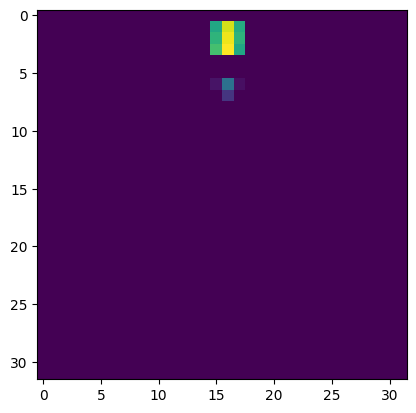

Text(0.5, 1.0, 'without cutout')

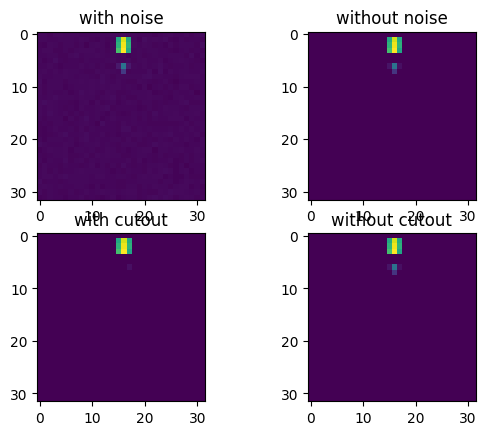

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].imshow(add_white_noise_image(X[0][0]))
axes[0, 0].set_title("with noise")
axes[0, 1].imshow(X[0][0])
axes[0, 1].set_title("without noise")

axes[1, 0].imshow(image_cutout(X[0][0]))
axes[1, 0].set_title("with cutout")
axes[1, 1].imshow(X[0][0])
axes[1, 1].set_title("without cutout")

In [75]:
def data_augment(X, Y, S, pourcentage):
    X_augmented = []
    Y_augmented = []
    S_augmented = []

    slice = int(X.shape[0] * pourcentage)

    data_ziped = list(zip(X[:slice], Y[:slice], S[:slice]))
    np.random.shuffle(data_ziped)

    #time shift
    for z in data_ziped:
        X_augmented.append(time_shift(z[0]))
        Y_augmented.append(z[1])
        S_augmented.append(z[2])
        
    for i, x in enumerate(X_augmented):
        for j, y in enumerate(x):
            X_augmented[i][j] = add_white_noise_image(y)
            X_augmented[i][j] = image_cutout(y)
    return np.array(X_augmented, dtype="object"), np.array(Y_augmented, dtype="object"), np.array(S_augmented, dtype="object")

# Data preprocess

In [13]:
def min_max_scaling_3d(data, a=0, b=1):
    # Calculate min and max along the specified axis
    min_vals = np.min(data)
    max_vals = np.max(data)
    
    # Perform Min-Max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals) * (b - a) + a
    
    return scaled_data

In [14]:
def pre_process_data(X, Y, S, apply_cov=False):
  X_cov, X_log = [], []
  if (apply_cov):
      X_cov = apply_cov(X)
  
  #apply log and reshape
  for x in X:
      sub_X_cov = []
      for y in x:
          sub_X_cov.append(np.log(y + 1e-3))
      X_log.append(np.array(sub_X_cov, dtype=np.float32))
            
  N = np.array(X_log, dtype="object")
  scalled = []
  #apply min max truncation
  for x in N:
      scalled.append(min_max_scaling_3d(x))

  return np.array(scalled, dtype="object") ,np.ravel(Y).astype('int'), np.ravel(S).astype('int')

# Implementation de l'architecture CNN, suivie de 3 layers pour la classification

In [15]:
def train_test_split(X, Y, test_size=0.4, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    combined_data = list(zip(X, Y))
    
    random.shuffle(combined_data)
    
    split_index = int(len(combined_data) * (1 - test_size))
    
    X_train = [sample[0] for sample in combined_data[:split_index]]
    Y_train = [sample[1] for sample in combined_data[:split_index]]
    X_test = [sample[0] for sample in combined_data[split_index:]]
    Y_test = [sample[1] for sample in combined_data[split_index:]]
    
    return X_train, X_test, Y_train, Y_test

In [52]:
class CNN(nn.Module):
    def __init__(self, num_class = 12):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
        
        self.output = nn.Linear(512, num_class) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 32)
        x_col = x.t()
        x_cov = torch.cov(x_col).flatten()
        x = F.relu(self.fc1(x_cov))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.output(x), dim=0)
        return x
    
    def prediction(self, x):
        pred = self.forward(x)
        return torch.argmax(pred).item()


# Preprocess the data

In [22]:
X_preprossed, Y_preprossed, S = pre_process_data(X, Y, S)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X_preprossed, Y_preprossed)

criterion = nn.CrossEntropyLoss()
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

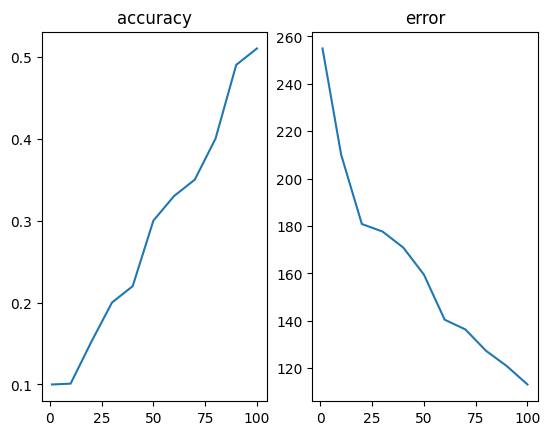

In [60]:
def train(X_train, X_test, Y_train, Y_test, eval=True):
    losses = []
    accuracy = []
    epochs = []
    for epoch in range(num_epochs):
        model.train()  
        for i, X in enumerate(X_train):
            #ajour d'une dimension pour le nombre de cannaux 
            X = torch.tensor(np.expand_dims(X, axis=1), dtype=torch.float32).to(device)
            y = torch.tensor([Y_train[i]], dtype=torch.long).to(device)
            outputs = model(X) 
            loss = criterion(outputs.unsqueeze(0), y) 
            optimizer.zero_grad() 
            loss.backward()  
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)      
            optimizer.step()      

        if (eval):
            #test
            with torch.no_grad():
                model.eval()
                total_loss = 0
                good_preds = 0
                total_preds = 0
                for i, X in enumerate(X_test):
                    X = torch.tensor(np.expand_dims(X, axis=1), dtype=torch.float32).to(device)
                    y = torch.tensor([Y_test[i]], dtype=torch.long).to(device)
                    pred = model(X)
                    total_loss += criterion(pred.unsqueeze(0), y)
                    if (torch.argmax(pred).item() == y.item()):
                        good_preds += 1
                    total_preds += 1
            losses.append(total_loss)
            accuracy.append(good_preds/total_preds)
            epochs.append(epoch)

            if (epoch%10==0):
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

    if (eval):
        _, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].plot(epochs, accuracy)    
        axes[0].set_title('accuracy')
        axes[1].plot(epochs, losses)
        axes[1].set_title('error')
        plt.show()

    return np.mean(np.array(accuracy))

train(X_train, X_test, Y_train, Y_test)

In [62]:
score = leave_one_out_cross_score(X_preprossed, Y_preprossed, S, train_method=train)
print(f"score for leave on out validation is {score}")

score for leave on out validation is 0.4955


# with data augmentation ...

In [88]:
X_augmented, Y_preprossed, S_augmented = data_augment(X_preprossed, Y_preprossed, S, pourcentage=0.10)
X_preprossed = np.concatenate((X_preprossed, X_augmented), axis=0)
Y_preprossed = np.concatenate((Y_preprossed, Y_preprossed), axis=0)
S = np.concatenate((S, S_augmented), axis=0)

print(X_preprossed.shape)

(24157,)


: 